In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
from sklearn.metrics import silhouette_score


In [2]:
df = pd.read_parquet('../data/Electric_Vehicle_Population_Data_cleaned.parquet')
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,CAFV_Class,Vehicle_Age,longitude,latitude
0,5YJ3E1EBXK,King,Seattle,WA,98178.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),220.0,59900.0,37.0,477309682,POINT (-122.23825 47.49461),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10,1,6,-122.23825,47.49461
1,5YJYGDEE3L,Kitsap,Poulsbo,WA,98370.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),291.0,59900.0,23.0,109705683,POINT (-122.64681 47.73689),PUGET SOUND ENERGY INC,5.303509e+10,1,5,-122.64681,47.73689
2,KM8KRDAF5P,Kitsap,Olalla,WA,98359.0,2023,HYUNDAI,IONIQ 5,Battery Electric Vehicle (BEV),72.0,59900.0,26.0,230390492,POINT (-122.54729 47.42602),PUGET SOUND ENERGY INC,5.303509e+10,0,2,-122.54729,47.42602
3,5UXTA6C0XM,Kitsap,Seabeck,WA,98380.0,2021,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),30.0,59900.0,35.0,267929112,POINT (-122.81585 47.64509),PUGET SOUND ENERGY INC,5.303509e+10,1,4,-122.81585,47.64509
4,JTMAB3FV7P,Thurston,Rainier,WA,98576.0,2023,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),42.0,59900.0,2.0,236505139,POINT (-122.68993 46.88897),PUGET SOUND ENERGY INC,5.306701e+10,1,2,-122.68993,46.88897


In [3]:
features = ['Electric Range', 'Vehicle_Age', 'Base MSRP']
df_features = df[features].copy()
df_features['EV_Type'] = df['Electric Vehicle Type'].map({'Battery Electric Vehicle (BEV)': 1, 'Plug-in Hybrid Electric Vehicle (PHEV)': 0})
df_features['Make_encoded'] = pd.factorize(df['Make'])[0]
df_features.head()

,Electric Range,Vehicle_Age,Base MSRP,EV_Type,Make_encoded
0,220.0,6,59900.0,1,0
1,291.0,5,59900.0,1,0
2,72.0,2,59900.0,1,1
3,30.0,4,59900.0,0,2
4,42.0,2,59900.0,0,3


In [4]:
features_for_clustering = ['Electric Range', 'Vehicle_Age', 'Base MSRP', 'EV_Type', 'Make_encoded']
X = df_features[features_for_clustering]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

In [5]:
sample_size = min(3000, int(0.1 * len(df_features)))
np.random.seed(42)
sample_indices = np.random.choice(len(df_features), sample_size, replace=False)
X_sample = scaled_features[sample_indices]

In [6]:
affinity_prop = AffinityPropagation(
    damping=0.9,
    max_iter=200,
    convergence_iter=15,
    random_state=42,
    preference=-1000  
)
cluster_labels = affinity_prop.fit_predict(X_sample)
n_clusters_ap = len(set(cluster_labels))
print(f"Anzahl der identifizierten Cluster: {n_clusters_ap}")

exemplar_indices = affinity_prop.cluster_centers_indices_
print(f"Anzahl der Exemplare: {len(exemplar_indices)}")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

Anzahl der identifizierten Cluster: 5
Anzahl der Exemplare: 5


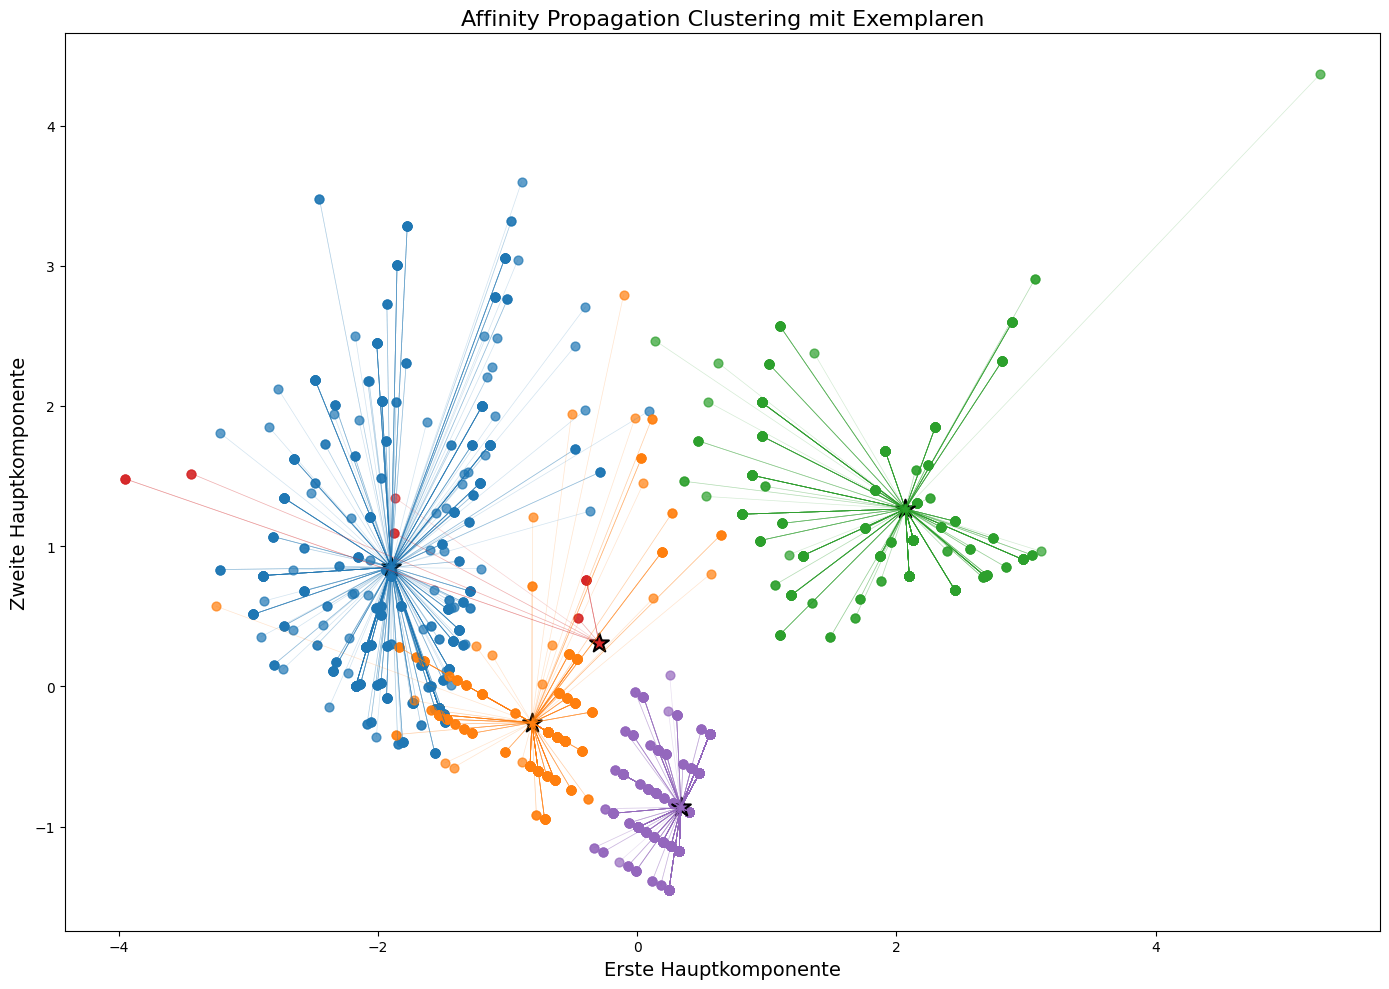

In [7]:
colors = list(mcolors.TABLEAU_COLORS.values())
color_map = {i: colors[i % len(colors)] for i in range(n_clusters_ap)}

plt.figure(figsize=(14, 10))

for i, exemplar_idx in enumerate(exemplar_indices):
    cluster_label = cluster_labels[exemplar_idx]
    member_indices = np.where(cluster_labels == cluster_label)[0]
    
    color = color_map[i % len(color_map)]
    
    for member_idx in member_indices:
        if member_idx == exemplar_idx:
            continue
            
        plt.plot(
            [X_pca[exemplar_idx, 0], X_pca[member_idx, 0]],
            [X_pca[exemplar_idx, 1], X_pca[member_idx, 1]],
            color=color,
            alpha=0.2,
            linewidth=0.5
        )
    
    # Zeichne Clusterpunkte
    plt.scatter(
        X_pca[member_indices, 0],
        X_pca[member_indices, 1],
        s=40,
        color=color,
        alpha=0.7,
        label=f'Cluster {i}'
    )
    
    # Markiere das Exemplar
    plt.scatter(
        X_pca[exemplar_idx, 0],
        X_pca[exemplar_idx, 1],
        s=200,
        color=color,
        marker='*',
        edgecolor='black',
        linewidth=1.5
    )

plt.title('Affinity Propagation Clustering mit Exemplaren', fontsize=16)
plt.xlabel('Erste Hauptkomponente', fontsize=14)
plt.ylabel('Zweite Hauptkomponente', fontsize=14)
# if n_clusters_ap <= 10:
#     plt.legend(title="Cluster", loc='best')

plt.tight_layout()
plt.show()

In [9]:

exemplars = X_sample[exemplar_indices]

# Berechne die Distanzen aller Datenpunkte zu jedem Exemplar
from sklearn.metrics.pairwise import euclidean_distances

distances_to_exemplars = euclidean_distances(scaled_features, exemplars)

# Weise jeden Punkt dem nächstgelegenen Exemplar/Cluster zu
assigned_labels_full = np.argmin(distances_to_exemplars, axis=1)
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(scaled_features, assigned_labels_full)
print(f"Calinski-Harabasz Score: {ch_score:.2f}")

Calinski-Harabasz Score: 110000.25


In [10]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(scaled_features, assigned_labels_full)
print(f"Davies-Bouldin Score: {db_score:.3f}")

Davies-Bouldin Score: 0.669
